# Echo State Stochastic Volatility Heston Dynamical Model

# The Modeling Perspective

This data is from SPX&500. Here, we're interested in modeling the stock price rather than modeling the option price, as of calculating option requires us model the stock price first. We know about the stock price follows the Heston Model:

\begin{aligned}
dS_t &= \mu S_t dt + \sqrt{v_t}S_td\tilde W_t \\
dv_t &= k(\mu - v_t)dt + \alpha \sqrt{v_t}d\tilde W_t'\\
\rho dt &= \mathbb{E}(d\tilde W_t+d\tilde W_t')
\end{aligned}

This does have a close solution by geometrical transformation. However, here we're using the Echo State Neural Network to model the volatility process $v_t$. Therefore, the heston model becomes:

\begin{aligned}
dS_t &= \mu S_t dt + \sqrt{v_t}S_td\tilde W_t \\
v_t &= \text{ESN}_t(\mathbf{u}(t), \mathbf{x}(t)) \\
\mathbf{u}(t) &= \text{return}(:t-1) \\
\mathbf{x}(t) &= \sigma_{\text{tanh}} ( \mathbf{W}_{\text{in}}\mathbf{u}(t) + \mathbf{W}_{\text{r}}(\mathbf{x}(t-1) + \epsilon) )
\end{aligned}

We might first model the constant drift geometric brownian motion process. Then, we can build another parallel ESN for forcasting the stochastic drift process, namely: 

\begin{aligned}
dS_t &= \mu_t S_t dt + \sqrt{v_t}S_td\tilde W_t \\
v_t &= \text{ESN}^1_t(\mathbf{u}(t), \mathbf{x}(t)) \\
\mu_t &= \text{ESN}^2_t(\mathbf{u}(t), \mathbf{x}(t))\\
\mathbf{u}(t) &= \text{return}(:t-1) \\
\mathbf{x}(t) &= \sigma_{\text{tanh}} ( \mathbf{W}_{\text{in}}\mathbf{u}(t) + \mathbf{W}_{\text{r}}(\mathbf{x}(t-1) + \epsilon) )
\end{aligned}



In [98]:

def EchoStateDeepTest(x_dim, connectivity, spectral_radius,
                  u_num, u_dim, u_mag,
                  leak, cutout, forget, 
                  cv_start, cv_end, cv_step, val_cut, verbose, input_U, target_Y, resvoir_num):
    if verbose:
        print()
        print("-----------------------------------------------Making Transition and input matrix------------------------------------------------")
        print()

    # Making inner transition sparse matrix W
    W_list = []
    for i in range(resvoir_num):
        nans = np.random.randint(0, int(1/connectivity)-1 , size=(x_dim, x_dim))
        W = np.random.uniform(-0.4, 0.4, x_dim*x_dim).reshape([x_dim, x_dim])
        W = np.where(nans, np.nan, W)
        W = np.nan_to_num(W)
        E, _ = np.linalg.eig(W)
        e_max = np.max(np.abs(E))
        W /= np.abs(e_max)/spectral_radius   
        W_list.append(W)

    # Making reservoir to reservoir transitional matrix 
    W_trans_list = []
    for i in range(resvoir_num-1):
        W_trans = np.random.uniform(-1, 1, x_dim*x_dim).reshape([x_dim, x_dim])
        W_trans_list.append(W_trans) 


    # Making input matrix W_in
    W_in = np.random.uniform(-1, 1, x_dim*u_dim).reshape([x_dim, u_dim])
    W_in = W_in / (np.linalg.svd(W_in)[1].tolist()[0]*1.2)

    if verbose:
        print("Shape of W: ", str(W.shape))
        print("Shape of W_in:", str(W_in.shape))

        print()
        print("-----------------------------------------------Making input and inner states------------------------------------------------------")
        print()




    # Making Inner States
    X = u

    x_lists = []
    x_list = [np.zeros([x_dim]), np.zeros([x_dim])]

    # 1st reservoir
    for i in range(u_num):
        x_next = (1-leak)*x_list[-2] + leak * np.tanh( np.matmul(W_in, u[i]) + np.matmul(W_list[0], x_list[-1] ) +  np.random.rand(x_dim))
        x_list.append(x_next)
    x_lists.append(x_list)

    # 2-last reservoirs
    for res in range(resvoir_num-1):
        x_list = [np.zeros([x_dim]), np.zeros([x_dim])]
        for i in range(u_num):
            x_next = (1-leak)*x_list[-2] + leak * np.tanh( np.matmul(W_trans_list[res], x_lists[res][i+2]) + np.matmul(W_list[res], x_list[-1] ) +  np.random.rand(x_dim))
            x_list.append(x_next)
        x_lists.append(x_list)

    states = np.array(x_lists[-1][1:]).reshape(u_num+1, x_dim)

    if verbose:
        print("Inner States: # of samples x # of dimension:", str(states.shape))
        print("Input States: # of samples x # of dimension:", str(u.shape))

        print()
        print("------------------------------------------------Concatenate data and Y sequence data------------------------------------------------")
        print()

        # Making Concatenated data

    X = np.concatenate([states[:-1,:], u], axis=1)
    X = X[:-1, :]





    # Faking Target sequence
    Y = target_Y


    if verbose:
        print("Inner + Input States: # of samples x # of dimension:", str(X.shape))
        print("Targeted fitting sequence: # of samples x # of dimension:", str(Y.shape))

        print()
        print("--------------------------------------------------Splitting Data to 3-------------------------------------------------------------")
        print()

    # Split into 3 trunks, usless trunk, regressing trunk, predicting trunk
    useless_X = X[:forget, :]
    useless_Y = Y[:forget, :]

    regress_X = X[forget:-cutout, :]
    regress_Y = Y[forget:-cutout, :]

    train_size = int(regress_X.shape[0]*(1-val_cut))

    train_X = np.split(regress_X, [train_size, regress_X.shape[0]+1])[0]
    train_Y = np.split(regress_Y, [train_size, regress_X.shape[0]+1])[0]

    val_X = np.split(regress_X, [train_size, regress_X.shape[0]+1])[1]
    val_Y = np.split(regress_Y, [train_size, regress_X.shape[0]+1])[1]

    predict_X = X[-cutout:, :]
    predict_Y = Y[-cutout:, :]

    if verbose:
        print("useless_X: # of samples x # of dimension:", str(useless_X.shape))
        print("useless_Y: # of samples x # of dimension:", str(useless_Y.shape))
        print("regress_X: # of samples x # of dimension:", str(regress_X.shape))
        print("regress_Y: # of samples x # of dimension:", str(regress_Y.shape))
        print("train_X: # of samples x # of dimension:", str(train_X.shape))
        print("train_Y: # of samples x # of dimension:", str(train_Y.shape))
        print("val_X: # of samples x # of dimension:", str(val_X.shape))
        print("val_Y: # of samples x # of dimension:", str(val_Y.shape))
        print("predict_X: # of samples x # of dimension:", str(predict_X.shape))
        print("predict_Y: # of samples x # of dimension:", str(predict_Y.shape))

        print()
        print("---------------------------------------------------Conducting Regression----------------------------------------------------------")
        print()

    alpha = cv_start
    mse = {}
    while alpha <= cv_end:

        # Conducting linear regression
        reg = Ridge(alpha).fit(train_X, train_Y)

        # Making prediction
        valhat_Y = reg.predict(val_X)
        alpha += cv_step

        loss = np.mean(np.multiply(   (val_Y - valhat_Y), (val_Y - valhat_Y)))
        mse[alpha] = loss


    best_mse = min(list(mse.values()))
    best_alpha = list(mse.keys())[list(mse.values()).index(best_mse)]


    # using best regression again
    reg = Ridge(best_alpha).fit(regress_X, regress_Y)

    # Making prediction
    predhat_Y = reg.predict(predict_X)

    # showing training error, 
    regrpred_Y = reg.predict(regress_X)
    train_mse = np.mean(np.multiply(   (regrpred_Y - regress_Y), (regrpred_Y - regress_Y)))
    pred_mse = np.mean(np.multiply(   (predhat_Y - predict_Y), (predhat_Y - predict_Y)))

    print("model ridge coefficient:", best_alpha)
    print("Model training mse:", train_mse)
    print("Model validation mse:", best_mse)
    print("Model prediction mse:", pred_mse)
    print("Model prediction average error", math.sqrt(pred_mse))

    if verbose:    
        print("regress coefficient length:", len(reg.coef_[0].tolist()))
        print("first 5 coefficient of model:", reg.coef_[0, :5])
        print("Predicted length equal to target length:", predhat_Y.shape==predict_Y.shape)

        print()
        print("-----------------------------------------------Producing Graphic Visualization----------------------------------------------------")
        print()


    # Producing Graphic Visualization

    # 后面100个，真实值与预测的
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.set_title('Predict and Groud Truth'.format("seaborn"), color='C0')   

    ax.plot([j for j in range(cutout)], [predict_Y[j] for j in range(predict_Y.shape[0])])
    ax.plot([j for j in range(cutout)], [predhat_Y[j] for j in range(predhat_Y.shape[0])], "--")


    # 所有的，真实值与预测的
    hat_Y = reg.predict(X)

    fig, ax = plt.subplots(figsize=(20, 5))
    ax.set_title('Predict and Groud Truth everything'.format("seaborn"), color='C1')   

    ax.plot([j for j in range(forget, u_num-1)], [Y[j] for j in range(forget, u_num-1)], ":", alpha = 0.7)
    ax.plot([j for j in range(forget, u_num-1)], [hat_Y[j] for j in range(forget, u_num-1)], "red", linewidth=1)
    ax.axvline(x=forget, ls = "--", c = "yellow")
    ax.axvline(x=u_num - cutout, ls = "--", c = "yellow")


    # Different in prediction
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.set_title('Predict and Groud Truth everything'.format("seaborn"), color='C1')   

    ax.plot([j for j in range(forget, u_num-1)], [Y[j]-hat_Y[j] for j in range(forget, u_num-1)], "black", linewidth=1)
    ax.axvline(x=forget, ls = "--", c = "yellow")
    ax.axvline(x=u_num - cutout, ls = "--", c = "yellow")


    # all predictor signals
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.set_title('all predictor signals'.format("seaborn"), color='C1')   
    for i in range(1):
        ax.plot([j for j in range(1, u_num-1)], [X[j, i] for j in range(1, u_num-1)], linewidth=0.5)
    for i in range(-1,-6, -1):
        ax.plot([j for j in range(1, u_num-1)], [X[j, i] for j in range(1, u_num-1)], linewidth=0.5)
    ax.axvline(x=forget, ls = "--", c = "yellow")
    ax.axvline(x=u_num - cutout, ls = "--", c = "yellow")

    return predict_Y

In [35]:
def EchoStateCovTest(x_dim, connectivity, spectral_radius,
                  u_num, u_dim, u_mag,
                  leak, cutout, forget, 
                  cv_start, cv_end, cv_step, val_cut, verbose, input_U, target_Y, resvoir_num):
    if verbose:
        print()
        print("-----------------------------------------------Making Transition and input matrix------------------------------------------------")
        print()

    # Making inner transition sparse matrix W
    W_list = []
    for i in range(resvoir_num):
        nans = np.random.randint(0, int(1/connectivity)-1 , size=(x_dim, x_dim))
        W = np.random.uniform(-0.4, 0.4, x_dim*x_dim).reshape([x_dim, x_dim])
        W = np.where(nans, np.nan, W)
        W = np.nan_to_num(W)
        E, _ = np.linalg.eig(W)
        e_max = np.max(np.abs(E))
        W /= np.abs(e_max)/spectral_radius   
        W_list.append(W)

    # Making input matrix W_in
    W_in = np.random.uniform(-1, 1, x_dim*u_dim).reshape([x_dim, u_dim])
    W_in = W_in / (np.linalg.svd(W_in)[1].tolist()[0]*1.2)

    if verbose:
        print("Shape of W: ", str(W.shape))
        print("Shape of W_in:", str(W_in.shape))

        print()
        print("-----------------------------------------------Making input and inner states------------------------------------------------------")
        print()

    # Making Inner States
    X = u
    
    for res in range(resvoir_num):
        x_list = [np.zeros([x_dim]), np.zeros([x_dim])]

        for i in range(u_num):
            x_next = (1-leak)*x_list[-2] + leak * np.tanh( np.matmul(W_in, u[i]) + np.matmul(W_list[res], x_list[-1] ) +  np.random.rand(x_dim))
            x_list.append(x_next)

        states = np.array(x_list[1:]).reshape(u_num+1, x_dim)

        if verbose:
            print("Inner States: # of samples x # of dimension:", str(states.shape))
            print("Input States: # of samples x # of dimension:", str(u.shape))

            print()
            print("------------------------------------------------Concatenate data and Y sequence data------------------------------------------------")
            print()

        # Making Concatenated data

        X = np.concatenate([states[:-1,:], u], axis=1)
    X = X[:-1, :]

    # Faking Target sequence
    Y = target_Y


    if verbose:
        print("Inner + Input States: # of samples x # of dimension:", str(X.shape))
        print("Targeted fitting sequence: # of samples x # of dimension:", str(Y.shape))

        print()
        print("--------------------------------------------------Splitting Data to 3-------------------------------------------------------------")
        print()

    # Split into 3 trunks, usless trunk, regressing trunk, predicting trunk
    useless_X = X[:forget, :]
    useless_Y = Y[:forget, :]

    regress_X = X[forget:-cutout, :]
    regress_Y = Y[forget:-cutout, :]
    
    train_size = int(regress_X.shape[0]*(1-val_cut))
    
    train_X = np.split(regress_X, [train_size, regress_X.shape[0]+1])[0]
    train_Y = np.split(regress_Y, [train_size, regress_X.shape[0]+1])[0]
       
    val_X = np.split(regress_X, [train_size, regress_X.shape[0]+1])[1]
    val_Y = np.split(regress_Y, [train_size, regress_X.shape[0]+1])[1]
        
    predict_X = X[-cutout:, :]
    predict_Y = Y[-cutout:, :]

    if verbose:
        print("useless_X: # of samples x # of dimension:", str(useless_X.shape))
        print("useless_Y: # of samples x # of dimension:", str(useless_Y.shape))
        print("regress_X: # of samples x # of dimension:", str(regress_X.shape))
        print("regress_Y: # of samples x # of dimension:", str(regress_Y.shape))
        print("train_X: # of samples x # of dimension:", str(train_X.shape))
        print("train_Y: # of samples x # of dimension:", str(train_Y.shape))
        print("val_X: # of samples x # of dimension:", str(val_X.shape))
        print("val_Y: # of samples x # of dimension:", str(val_Y.shape))
        print("predict_X: # of samples x # of dimension:", str(predict_X.shape))
        print("predict_Y: # of samples x # of dimension:", str(predict_Y.shape))

        print()
        print("---------------------------------------------------Conducting Regression----------------------------------------------------------")
        print()

    alpha = cv_start
    mse = {}
    while alpha <= cv_end:

        # Conducting linear regression
        reg = Ridge(alpha).fit(train_X, train_Y)

        # Making prediction
        valhat_Y = reg.predict(val_X)
        alpha += cv_step

        loss = np.mean(np.multiply(   (val_Y - valhat_Y), (val_Y - valhat_Y)))
        mse[alpha] = loss


    best_mse = min(list(mse.values()))
    best_alpha = list(mse.keys())[list(mse.values()).index(best_mse)]


    # using best regression again
    reg = Ridge(best_alpha).fit(regress_X, regress_Y)

    # Making prediction
    predhat_Y = reg.predict(predict_X)
    
    # showing training error, 
    regrpred_Y = reg.predict(regress_X)
    train_mse = np.mean(np.multiply(   (regrpred_Y - regress_Y), (regrpred_Y - regress_Y)))
    pred_mse = np.mean(np.multiply(   (predhat_Y - predict_Y), (predhat_Y - predict_Y)))
    
    print("model ridge coefficient:", best_alpha)
    print("Model training mse:", train_mse)
    print("Model validation mse:", best_mse)
    print("Model prediction mse:", pred_mse)
    print("Model prediction average error", math.sqrt(pred_mse))

    if verbose:    
        print("regress coefficient length:", len(reg.coef_[0].tolist()))
        print("first 5 coefficient of model:", reg.coef_[0, :5])
        print("Predicted length equal to target length:", predhat_Y.shape==predict_Y.shape)

        print()
        print("-----------------------------------------------Producing Graphic Visualization----------------------------------------------------")
        print()


    # Producing Graphic Visualization

    # 后面100个，真实值与预测的
    fig, ax = plt.subplots(figsize=(20, 3))
    ax.set_title('Predict and Groud Truth'.format("seaborn"), color='C0')   

    ax.plot([j for j in range(cutout)], [predict_Y[j] for j in range(predict_Y.shape[0])])
    ax.plot([j for j in range(cutout)], [predhat_Y[j] for j in range(predhat_Y.shape[0])], "--")


    # 所有的，真实值与预测的
    hat_Y = reg.predict(X)

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title('Predict and Groud Truth everything'.format("seaborn"), color='C1')   

    ax.plot([j for j in range(forget, u_num-1)], [Y[j] for j in range(forget, u_num-1)], ":", alpha = 0.7)
    ax.plot([j for j in range(forget, u_num-1)], [hat_Y[j] for j in range(forget, u_num-1)], "red", linewidth=1)
    ax.axvline(x=forget, ls = "--", c = "yellow")
    ax.axvline(x=u_num - cutout, ls = "--", c = "yellow")

    
    # Different in prediction
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title('Predict and Groud Truth everything'.format("seaborn"), color='C1')   

    ax.plot([j for j in range(forget, u_num-1)], [Y[j]-hat_Y[j] for j in range(forget, u_num-1)], "black", linewidth=1)
    ax.axvline(x=forget, ls = "--", c = "yellow")
    ax.axvline(x=u_num - cutout, ls = "--", c = "yellow")


    # all predictor signals
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.set_title('all predictor signals'.format("seaborn"), color='C1')   
    for i in range(1):
        ax.plot([j for j in range(1, u_num-1)], [X[j, i] for j in range(1, u_num-1)], linewidth=0.5)
    for i in range(-1,-6, -1):
        ax.plot([j for j in range(1, u_num-1)], [X[j, i] for j in range(1, u_num-1)], linewidth=0.5)
    ax.axvline(x=forget, ls = "--", c = "yellow")
    ax.axvline(x=u_num - cutout, ls = "--", c = "yellow")

In [66]:
def EchoStateTest(x_dim, connectivity, spectral_radius,
                  u_num, u_dim, u_mag,
                  leak, cutout, forget, 
                  cv_start, cv_end, cv_step, val_cut, verbose, input_U, target_Y):
    if verbose:
        print()
        print("-----------------------------------------------Making Transition and input matrix------------------------------------------------")
        print()

    # Making inner transition sparse matrix W
    nans = np.random.randint(0, int(1/connectivity)-1 , size=(x_dim, x_dim))
    W = np.random.uniform(-0.4, 0.4, x_dim*x_dim).reshape([x_dim, x_dim])
    W = np.where(nans, np.nan, W)
    W = np.nan_to_num(W)
    E, _ = np.linalg.eig(W)
    e_max = np.max(np.abs(E))
    W /= np.abs(e_max)/spectral_radius   


    # Making input matrix W_in
    W_in = np.random.uniform(-1, 1, x_dim*u_dim).reshape([x_dim, u_dim])
    W_in = W_in / (np.linalg.svd(W_in)[1].tolist()[0]*1.2)

    if verbose:
        print("Shape of W: ", str(W.shape))
        print("Shape of W_in:", str(W_in.shape))

        print()
        print("-----------------------------------------------Making input and inner states------------------------------------------------------")
        print()

    # Making Inner States
    x_list = [np.zeros([x_dim]), np.zeros([x_dim])]
    
    for i in range(u_num):
        x_next = (1-leak)*x_list[-2] + leak * np.tanh( np.matmul(W_in, u[i]) + np.matmul(W, x_list[-1] ) +  np.random.rand(x_dim))
        x_list.append(x_next)

    states = np.array(x_list[1:]).reshape(u_num+1, x_dim)

    if verbose:
        print("Inner States: # of samples x # of dimension:", str(states.shape))
        print("Input States: # of samples x # of dimension:", str(u.shape))

        print()
        print("------------------------------------------------Concatenate data and Y sequence data------------------------------------------------")
        print()

    # Making Concatenated data
    
    X = np.concatenate([states[:-1,:], u], axis=1)
    X = X[:-1, :]

    # Faking Target sequence
    Y = target_Y
    print("Y shape:", Y.shape)


    if verbose:
        print("Inner + Input States: # of samples x # of dimension:", str(X.shape))
        print("Targeted fitting sequence: # of samples x # of dimension:", str(Y.shape))

        print()
        print("--------------------------------------------------Splitting Data to 3-------------------------------------------------------------")
        print()

    # Split into 3 trunks, usless trunk, regressing trunk, predicting trunk
    useless_X = X[:forget, :]
    useless_Y = Y[:forget, :]

    regress_X = X[forget:-cutout, :]
    regress_Y = Y[forget:-cutout, :]
    
    train_size = int(regress_X.shape[0]*(1-val_cut))
    
    train_X = np.split(regress_X, [train_size, regress_X.shape[0]+1])[0]
    train_Y = np.split(regress_Y, [train_size, regress_X.shape[0]+1])[0]
       
    val_X = np.split(regress_X, [train_size, regress_X.shape[0]+1])[1]
    val_Y = np.split(regress_Y, [train_size, regress_X.shape[0]+1])[1]
        
    predict_X = X[-cutout:, :]
    predict_Y = Y[-cutout:, :]

    if verbose:
        print("useless_X: # of samples x # of dimension:", str(useless_X.shape))
        print("useless_Y: # of samples x # of dimension:", str(useless_Y.shape))
        print("regress_X: # of samples x # of dimension:", str(regress_X.shape))
        print("regress_Y: # of samples x # of dimension:", str(regress_Y.shape))
        print("train_X: # of samples x # of dimension:", str(train_X.shape))
        print("train_Y: # of samples x # of dimension:", str(train_Y.shape))
        print("val_X: # of samples x # of dimension:", str(val_X.shape))
        print("val_Y: # of samples x # of dimension:", str(val_Y.shape))
        print("predict_X: # of samples x # of dimension:", str(predict_X.shape))
        print("predict_Y: # of samples x # of dimension:", str(predict_Y.shape))

        print()
        print("---------------------------------------------------Conducting Regression----------------------------------------------------------")
        print()

    alpha = cv_start
    mse = {}
    while alpha <= cv_end:

        # Conducting linear regression
        reg = Ridge(alpha).fit(train_X, train_Y)

        # Making prediction
        valhat_Y = reg.predict(val_X)
        alpha += cv_step

        loss = np.mean(np.multiply(   (val_Y - valhat_Y), (val_Y - valhat_Y)))
        mse[alpha] = loss


    best_mse = min(list(mse.values()))
    best_alpha = list(mse.keys())[list(mse.values()).index(best_mse)]


    # using best regression again
    reg = Ridge(best_alpha).fit(regress_X, regress_Y)

    # Making prediction
    predhat_Y = reg.predict(predict_X)
    
    # showing training error, 
    regrpred_Y = reg.predict(regress_X)
    train_mse = np.mean(np.multiply(   (regrpred_Y - regress_Y), (regrpred_Y - regress_Y)))
    pred_mse = np.mean(np.multiply(   (predhat_Y - predict_Y), (predhat_Y - predict_Y)))
    
    print("model ridge coefficient:", best_alpha)
    print("Model training mse:", train_mse)
    print("Model validation mse:", best_mse)
    print("Model prediction mse:", pred_mse)
    print("Model prediction average error", math.sqrt(pred_mse))

    if verbose:    
        print("regress coefficient length:", len(reg.coef_[0].tolist()))
        print("first 5 coefficient of model:", reg.coef_[0, :5])
        print("Predicted length equal to target length:", predhat_Y.shape==predict_Y.shape)

        print()
        print("-----------------------------------------------Producing Graphic Visualization----------------------------------------------------")
        print()


    # Producing Graphic Visualization

    # 后面100个，真实值与预测的
    mpl.style.use("seaborn")
    fig, ax = plt.subplots(figsize=(20, 3))
    ax.set_title('Predict and Groud Truth'.format("seaborn"), color='C0')   

    ax.plot([j for j in range(cutout)], [predict_Y[j] for j in range(predict_Y.shape[0])])
    ax.plot([j for j in range(cutout)], [predhat_Y[j] for j in range(predhat_Y.shape[0])], "--")


    # 所有的，真实值与预测的
    hat_Y = reg.predict(X)


    mpl.style.use("seaborn")
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title('Predict and Groud Truth everything'.format("seaborn"), color='C1')   

    ax.plot([j for j in range(forget, u_num-1)], [Y[j] for j in range(forget, u_num-1)], ":", alpha = 0.7)
    ax.plot([j for j in range(forget, u_num-1)], [hat_Y[j] for j in range(forget, u_num-1)], "red", linewidth=1)
    ax.plot([j for j in range(forget, u_num-1)], [Y[j]-hat_Y[j] for j in range(forget, u_num-1)], "black", linewidth=1)
    ax.axvline(x=forget, ls = "--", c = "yellow")
    ax.axvline(x=u_num - cutout, ls = "--", c = "yellow")


    # all predictor signals
    mpl.style.use("seaborn")
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.set_title('all predictor signals'.format("seaborn"), color='C1')   
    for i in range(1):
        ax.plot([j for j in range(1, u_num-1)], [X[j, i] for j in range(1, u_num-1)], linewidth=0.5)
    for i in range(-1,-6, -1):
        ax.plot([j for j in range(1, u_num-1)], [X[j, i] for j in range(1, u_num-1)], linewidth=0.5)
    ax.axvline(x=forget, ls = "--", c = "yellow")
    ax.axvline(x=u_num - cutout, ls = "--", c = "yellow")

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import seaborn as sns
import math
import os
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

def 


In [154]:
class EchoStateDeep():
    """
    A Echo State Neural Network that can obtain deep structure
    :param self.leak: The leaky rate of ESN in [0,1]
    :param self.resvoir_num: number of layers of reservoir
    :param self.encorporate: whether concatenate input with states when making prediction
    :param x_dim: square root of state dimension (side length of W matrix), x_dim * x_dim = state dimension
    :param u_dim: dimension of the direct input signal
    :param W_list: list of W(s) in each reservoir layer 
    :param W_trans_list: list of reservoir-to-reservoir transition matrix
    :param W_in: the input matrix in the preceding first layer of reservoir
    :param model: the linear regression model of the Echo State Network object
    
    :return: a Deep Echo State Network Object
    """
    
    def __init__(self, leak, resvoir_num, encorporate = True):
        """
        Initialize ESN object leaky rate, reservoir depth, and predictor input concatenation indication
        
        :param leak: leaky rate, used to initialize self.leak
        :param resvoir_num, number of reservoir, used to initalize self.resvoir_num
        :param encorporate, BOOL, True is concatenate, False is not concenate
        """
        
        self.leak = leak
        self.resvoir_num = resvoir_num
        self.encorporate = encorporate

    def make_weights(self, x_dim, u_dim, connectivity, spectral_radius):
        """
        Initialize deep ESN W_in, W(s), W_trans(s) matrices
        
        :param x_dim: used to initialize self.x_dim
        :param u_dim: used to initialize self.u_dim
        :param connectivity: connectivity of the W matrices
        :param spectral_radius: spectral_radius of the W matrices
        """
        # State dimension x_dim * x_dim
        self.x_dim = x_dim
        
        # Input dimension
        self.u_dim = u_dim
        
        # Making inner transition sparse matrix self.W     
        self.W_list = []
        for i in range(self.resvoir_num):
            nans = np.random.randint(0, int(1/connectivity)-1 , size=(x_dim, x_dim))
            W = np.random.uniform(-0.4, 0.4, x_dim*x_dim).reshape([x_dim, x_dim])
            W = np.where(nans, np.nan, W)
            W = np.nan_to_num(W)
            E, _ = np.linalg.eig(W)
            e_max = np.max(np.abs(E))
            W /= np.abs(e_max)/spectral_radius   
            self.W_list.append(W)

        # making reservoir to reservoir transition matrix [self.W_trans]
        self.W_trans_list = []
        for i in range(self.resvoir_num-1):
            W_trans = np.random.uniform(-1, 1, x_dim*x_dim).reshape([x_dim, x_dim])
            self.W_trans_list.append(W_trans) 


        # Making input matrix self.W_in
        self.W_in = np.random.uniform(-1, 1, self.x_dim*self.u_dim).reshape([self.x_dim, self.u_dim])
        self.W_in = self.W_in / (np.linalg.svd(self.W_in)[1].tolist()[0]*1.2)
    
    def make_state(self, u_input):
        # X_lists is a list of reservoir list (X_list)
        # X_list is a list of reservoir states
        x_lists = []
        
        # Give the initial 2 empty states, 
        # 1st one for previous state, compensating leaky operator
        # 2nd one for current state, integrated to compute next state 
        x_list = [np.zeros([self.x_dim]), np.zeros([self.x_dim])]
        
        u_num = u_input.shape[0]
        # making 1st reservoir inner states
        for i in range(u_num-1): # Do not use the last input to predict an extra state.
                                 # State and input ending same length
            x_next = (1-leak)*x_list[-2] + leak * np.tanh(np.matmul(self.W_in, u_input[i]) + 
                                                          np.matmul(self.W_list[0], x_list[-1] ) +  
                                                          np.random.rand(self.x_dim))
            x_list.append(x_next)
        x_lists.append(x_list)

        # 2-last reservoirs
        for res in range(self.resvoir_num-1):
            x_list = [np.zeros([self.x_dim]), np.zeros([self.x_dim])]
            for i in range(u_num-1):  # Do not use the last input to predict an extra state.
                                      # State and input ending same length
                x_next = (1-leak)*x_list[-2] + leak * np.tanh(np.matmul(self.W_trans_list[res], x_lists[res][i+2] + # previous reservoir's states as input
                                                              np.matmul(self.W_list[res], x_list[-1] ) +            # last state of this reservoir
                                                              np.random.rand(self.x_dim)/10 ))                       # perturbing gaussian noise, std=0.1
                x_list.append(x_next)
            x_lists.append(x_list)
            
        return x_lists
            
            
    def make_X(self, u_input):
        """
        Computing all states (concatenated with inpulse signal), X, that can 
        be generated by u_input without further input
        
        :param u_input: the direct inpulse signal
        
        :return the finalized predictor variable X
        """
        x_lists = self.make_state(u_input)
        
        # eliminate first null state as it is used for leak operator, no input signal aligns with it
        X = np.array(x_lists[-1][1:]).reshape(u_num, self.x_dim) 
        
        # if also encorporate input signal as part of predictor data X
        if self.encorporate:
            X = np.concatenate([X, u_input], axis=1) 
        
        if not self.encorporate:
            X = X
        
        # eliminate last state because there is no u signal for it
        X = X[:-1, :]
        
        return X
                                                              
    def train(self, u_input, Y_target, forget, cv_start=0, cv_end=1, cv_step=0.01, val_cut=0.25):
        """
        Train the model
        
        :param u_input: inpulse signal
        :param Y_target: target signal
        :param forget: the index after which the X is used for regression, due to memory vanishing
        :param cv_start: the starting alpha value for validation
        :param cv_end: the ending alpha value for validation
        :param cv_step: the step wise increase of alpha for validation
        :param val_cut: training and validation split ratio
        
        :return self.model
        """                                              
        # Make training predicting variable
        regress_X = self.make_X(u_input)[forget:]
        regress_Y = Y_target[forget:]
                       
        train_size = int(regress_X.shape[0]*(1-val_cut))
        Xtrain, Xval = np.split(regress_X, [train_size])
        Ytrain, Yval = np.split(regress_Y, [train_size])
                                       
        # validation
        alpha = cv_start
        mse = {}
        while alpha <= cv_end:

            # Conducting linear regression
            reg = Ridge(alpha).fit(Xtrain, Ytrain)

            # Making prediction
            Yval_hat = reg.predict(Xval)
            alpha += cv_step

            loss = np.mean(np.multiply(   (Yval - Yval_hat), (Yval - Yval_hat)))
            mse[alpha] = loss

        best_mse = min(list(mse.values()))
        best_alpha = list(mse.keys())[list(mse.values()).index(best_mse)]
        
        self.model = Ridge(best_alpha).fit(regress_X, regress_Y)
        
    def predict_with_true_input(self, u_input, Y_true, predict_index):
        """
        Make prediction with consecutive true input, State NOT depending on output feedback
        
        :param u_input: input signal [--forget--(forget_index)--predict]
        :param Y_true: target signal [--forget--(forget_index)--predict]
        :param predict_index: before which the state is built to bulge memory.
                              aka, after which is used for prediction
        """
        X = self.make_X(u_input)
        X_pred = X[predict_index:]
        Y_pred = Y_true[predict_index:]

        Y_hat = self.model.predict(X_pred)
        pred_mse = np.mean(np.multiply(   (Y_pred - Y_hat), (Y_pred - Y_hat)))
        
        print("Model prediction mse:", pred_mse)
        print("Model prediction average error", math.sqrt(pred_mse))
        
    def extend_by_one(self, u_input_last, x_all_resvoir):
        """
        Extend reservoir state and predictor X by 1 
        
        :param u_input_last: the last calculated input signal
        :param x_all_resvoir: a LIST of all previous reservoir states ARRAY, 
            indexing: x_all_resvoir[i] is the (i+1)th reservoir; x_all_resvoir[][-j,:], the last jth state of the reservoir
        
        :return x_all_reservoir: the extended all reservoir state list
        :return X: the predictor for the next time step
        """
        # 1st reservoir: x_all_resvoir[0] indicate the first reservoir
        x_one_next = (1-leak)*x_all_resvoir[0][-2,:] + leak * np.tanh(np.matmul(self.W_in, u_input_last) + # current input as input signal
                                                                   np.matmul(self.W_list[0], x_all_resvoir[0][-1,:]) + # last state of this reservoir
                                                                   np.random.rand(self.x_dim)/10) # perturbing gaussian noise, std=0.1
        x_all_resvoir[0].append(x_one_next)

        # 2-last reservoirs
        for i in range(self.resvoir_num-1):                # indexing: x_all_resvoir[i+1] indicate the current reservoir
            x_next = (1-leak)*x_all_resvoir[i+1][-2,:] + \
                      leak * np.tanh(np.matmul(self.W_trans_list[res], x_all_resvoir[i][-1,:]) + # previous reservoir's states as input
                      np.matmul(self.W_list[res], x_all_resvoir[i+1][-1,:] ) +            # last state of this reservoir
                      np.random.rand(self.x_dim)/10 )                       # perturbing gaussian noise, std=0.1
            x_all_resvoir[i+1].append(x_next)
            
        
        
        # if also encorporate input signal as part of predictor data X
        if self.encorporate:
            X = np.concatenate([x_all_resvoir[-1][-1,:], u_input], axis=1)
        
        if not self.encorporate:
            X = x_all_resvoir[-1][-1,:]
        
        return x_all_resvoir, X
        
    def make_one_prediction(self, X):
        """
        Predict one step given the X predictor
        
        :param X, the one more step predictor variable
        """
        return self.model.predict(X)
    
        
    def predict_without_true_input(self, u_input, Y_true, predict_index):
        """
        :param u_input: input signal [--forget--(forget_index)---null---]
        :param Y_true: target signal [--forget--(forget_index)--predict-]
        State NOT depending on output feedback
        """
        Y_pred = u_input
        
        x_all_resvoir = self.make_state(u_input)
        
        while Y_pred.shape != Y_true.shape:
            
            x_all_resvoir, X= self.extend_by_one(x_all_resvoir)
            Y_u_next = self.make_one_prediction(X)
            Y_pred = np.concatenate([])
            
        # showing training error, 
        regrpred_Y = reg.predict(regress_X)
        train_mse = np.mean(np.multiply(   (regrpred_Y - regress_Y), (regrpred_Y - regress_Y)))
        pred_mse = np.mean(np.multiply(   (predhat_Y - predict_Y), (predhat_Y - predict_Y)))

        print("model ridge coefficient:", best_alpha)
        print("Model training mse:", train_mse)
        print("Model validation mse:", best_mse)
        print("Model prediction mse:", pred_mse)
        print("Model prediction average error", math.sqrt(pred_mse))

# 1 The Constant $\mu$ modeling
## 1.1 Choosing the appropriate data set
Due to the fact that we're assuming that $\mu$ as a constant (process), we're avoiding the time period where "black swan" occurs. The following segment of SPX500 data looks like a good fit!

The data contains 1469 seqential observations.


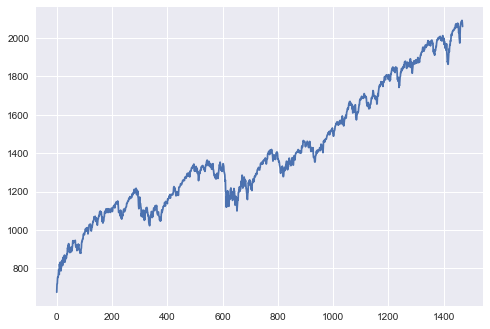

In [15]:
data = pd.read_csv("./SPX500.TXT", names = ["date", "open","high", "low", "close"], delimiter=" ", index_col =False)
close_p = data["close"].values

start = close_p.tolist().index(np.min(close_p))
data = close_p[start:]
data

mpl.style.use("seaborn")
plt.plot(data)
print("The data contains {} seqential observations.".format(data.shape[0]))

# 1.2 Define the geometric brownian motion

**Parameter:**
$r_t$: stock prices at time t

By definition, the process defined by $dS_t = \mu S_t dt + \sqrt{v_t}S_td\tilde W_t$ is a geometric brownian motion. The property is: $S(t+\Delta t) - S(t) \sim N(\mu, \Delta t v_t)$. 

We first do frequensist inference for the constant drift $\mu$. To do this, we add up all the segment differences $\sum_n^{1469-1}\Delta r_{t_n} = \sum_n^{1468}(r_{t_n}-r_{t_{n+1}})$. ( The reason why it is 1469 is that we have 1469 data points, therefore we have 1468 segments):

\begin{aligned}
S(t+\Delta t) - S(t) &\sim N(\mu, \Delta t v_t) \\
\frac{1}{1468}\sum_n^{1468}\Delta r_{t_n} &\sim N(\mu, \frac{\Delta t \sum_n v_{t_n}}{1468}) 
\end{aligned}

Therefore, from frequensist view, that $\frac{1}{1468}\sum_n^{1468}\Delta r_{t_n}$ is an unbiased and efficient estimator for $\mu$. We might be aware of the fact that this distribution has parameter $\Delta t$. How big a difference exactly is this difference in time? It doesn't matter in this modeling process (in fact it is a trading day) as the volatility $v_t$ can be adaptively scaled up or down to fit the curve. Therefore, it suffice to regard $\Delta t = 1$, leading to:

\begin{aligned}
\frac{1}{1468}\sum_n^{1468}\Delta r_{t_n} &\sim N(\mu, \frac{\sum_n v_{t_n}}{1468}) 
\end{aligned}

In [16]:
# Inferencing the value of mu
avg_mu = 0
cutout = 200

length = data.shape[0]
for i in range(length-1-cutout):
    avg_mu += data[i+1] - data[i]
avg_mu /= (data.shape[0]-1)

print("average increase in stock price is : {}".format(avg_mu))

average increase in stock price is : 0.8145231607629428


## 1.3 Constructing required dataset

We're making the data input and the fitting target. 


First, we transform stock price data into matrix. Notice that as we're feeding in vector, we can feed in consecutive days (e.g. 5 days) as one sample. This will manually bring longer past memory into the Echo State Network and therefore better deal with long-term memory fitting.

Second, as the target output is a the return at the next time step, which follows the distribution $r_{t+1} \sim N(r_t+\mu, v_{t+1})$, where $v_{t+1}$ is the parameter we're interested in, the key is to maximize the log likelihood of $r_{t+1}$ by nicely predicting $v_{t+1}$:

\begin{aligned}
    \ell(r_{t+1}; r_{t}, \mu, v_{t+1}) &= \log(\frac{1}{\sqrt{2\pi v_{t+1}}}\mathrm{ Exp}\{-\frac{(r_{t+1}-r_{t}-\mu)^2}{2v_{t+1}}\})\\
    &= -\frac{1}{2}\log{(2\pi v_{t+1})}-\frac{(r_{t+1}-r_{t}-\mu)^2}{2v_{t+1}}\\
    &= -\frac{1}{2}\log{(2\pi)}-\frac{1}{2}\log{v_{t+1}}-\frac{(r_{t+1}-r_{t}-\mu)^2}{2v_{t+1}}
\end{aligned}

It is easy to picture that there the function $f(v_{t+1}) = \ell(r_{t+1}; r_{t}, \mu, v_{t+1})$ is a convex function. Therefore, to get the global maximum, we merely need to use calculate derivative to get local maxima (\bf NOTE: the minima doesn't exist as the pdf can be arbiturarily flat so that the likelihood will go to 0) :

\begin{aligned}
    \frac{d\ell(r_{t+1}; r_{t}, \mu, v_{t+1})}{dv_{t+1}} &= -\frac{1}{2v_{t+1}} + \frac{(r_{t+1}-r_{t}-\mu)^2}{2v_{t+1}^2} = 0\\
    v_{t+1} &= (r_{t+1}-r_{t}-\mu)^2 \geq 0
\end{aligned}

In order to make sure that during prediction phase, the model won't predict a negative variance, we'd take the square root of the target variance and let ESN to predict the standard deviation instead. After squareing the standard deviation, we'll end up with a non negative variance:

\begin{aligned}
    \sigma_{t} &= \sqrt{r_t} = |r_{t+1}-r_{t}-\mu|
\end{aligned}


The calculated value is the target output sequence

**NOTE: target should be 1 sample less than input, as for t at last, there is nothing to be predicted, aka, lack of one future prediction target value for the last input sample**

In [56]:
# Making input states
u_dim = 200
u_num = length + 1 - u_dim

u = []
for i in range(u_num):
    ui = []
    for j in range(u_dim):
        ui.append(data[i+j])
    ui = np.array(ui)
    u.append(ui)
u = np.array(u).reshape(u_num, u_dim)

# Making target states
r_t_1 = data[u_dim:]
r_t_0 = data[u_dim-1:-1]
target = np.reshape(np.abs(r_t_1 - r_t_0 - avg_mu), [-1,1])

print("shape of input: (#samples, #dimensions): {}".format(u.shape))
print("shape of target: (#samples, #dimensions): {}".format(target.shape))

shape of input: (#samples, #dimensions): (1270, 200)
shape of target: (#samples, #dimensions): (1269, 1)


## 1.4 Plug in data and start the training

We need to normalize the input data to make it not too big that dominates the previous tanh state which ranges between -1 and 1. Below are all extra needed parameters needed for training the Echo State Network

### Parameters
**u_dim:** (above) dimension of input data (how many consecutive days)  
**u_num:** (above) length of input data (how many days of observations)  
**u_mag:** scale of magnitude of entries of input data (np.max(u)=u_mag)  
**x_dim:** dimension of inner state  
**connectivity:** level of connectivity, range between $[0,1]$  
**spectral_radius:** spectral radius of $\mathbf{W}_{\text{r}}$   
**cutout:** (above) number of observation at the end for prediction   
**forget:** number of observation at the begining not participating model training   
**cv_start:** the lower bound of alpha coefficient for ridge regression validation   
**cv_end:** the upper bound of alpha coefficient for ridge regression validation   
**cv_step:** the step of increment for alpha for ridge regression validation   
**val_cut:** the proportion between validation set and training set, $=\frac{\# \text{validation}}{\# \text{training}}$   
**verbose:** for debug mode, =True will return information of model parameters   

In [155]:
x_dim = 35
connectivity = 0.08
spectral_radius = 0.6

u_mag = 1


leak = 1 # the bigger the more focused on present

forget = 300

cv_start = 0
cv_end = 1
cv_step = 0.01
val_cut = 0.2

verbose = False


u = u/np.max(u) * u_mag



ESN = EchoStateDeep(leak, resvoir_num=1, encorporate = True)
ESN.make_weights(x_dim, u_dim, connectivity, spectral_radius)
ESN.train(u, target, forget)
ESN.predict_with_true_input(u, target, forget)




Model prediction mse: 76.29955130873182
Model prediction average error 8.734961437163408


In [ ]:
"""
pred_std = EchoStateDeepTest(x_dim, connectivity, spectral_radius,
                u_num, u_dim, u_mag,
                  leak, cutout, forget, 
                  cv_start, cv_end, cv_step, val_cut, verbose, u, target, resvoir_num=1)

pred = [data[-cutout-1]]

for i in range(cutout):
    pred.append(pred[-1]+np.random.normal(avg_mu, pred_std[i]))

pred = np.array(pred[1:])
print(np.mean( np.power(pred-data[-cutout:], 2)  ))

mpl.style.use("seaborn")
fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title('all predictor signals'.format("seaborn"), color='C1')
ax.plot([j for j in range(cutout)], [data[-cutout:][j] for j in range(cutout)])
ax.plot([j for j in range(cutout)], [pred[j] for j in range(cutout)], "--")
"""